# Endymion — Prototype Pipeline (Official Demo)

This notebook runs the **Endymion prototype pipeline** end-to-end:
- Load lunar DEM data (LOLA)
- Extract a canonical Region of Interest (ROI)
- Compute slope and roughness features
- Generate a terrain hazard map
- Run hazard-aware navigation (corridor-based Weighted A*)
- Save outputs and evaluation artefacts for reproducibility

**Note:** I maintain a separate *working* notebook for experimentation and debugging.


## 1. Environment setup (GitHub + paths)
I fetch the repository and configure the Python path so this notebook can run reproducibly in Colab.


In [18]:
REPO_URL = "https://github.com/Log-Yair/Endymion.git"
REPO_DIR = "/content/Endymion"
BRANCH = "src"

import os, sys

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL} {REPO_DIR}

%cd {REPO_DIR}
!git checkout {BRANCH}
!git pull


/content/Endymion
Branch 'src' set up to track remote branch 'src' from 'origin'.
Switched to a new branch 'src'
Already up to date.


## 2. Import project components
In this section, I import the backend components used by the prototype pipeline.


In [19]:
# References / origin notes:
# - Standard Colab pattern: add repo + src folder to sys.path so local modules can be imported.

import sys

# Add repo root
if REPO_DIR not in sys.path:
    sys.path.append(REPO_DIR)

# Add src folder (module files live here)
SRC_DIR = f"{REPO_DIR}/src"
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

print("Repo dir:", REPO_DIR)
print("Src dir :", SRC_DIR)


Repo dir: /content/Endymion
Src dir : /content/Endymion/src


In [20]:
# Imports match  Phase-1 module layout in src/
# data_handler.py, feature_extractor.py, hazard_assessor.py, pathfinder.py, evaluator.py

import numpy as np
from data_handler import DataHandler, LOLATileSpec, CANONICAL_ROI
from feature_extractor import FeatureExtractor
from hazard_assessor import HazardAssessor
from pathfinder import Pathfinder, build_cost_from_hazard, make_corridor_mask
from evaluator import Evaluator


## 3. Storage configuration
At this stage, I save derived products and outputs to Google Drive to support rapid iteration.
For other users, Drive is optional — the pipeline can also run using local Colab storage.


In [8]:
# References / origin notes:
# - Pattern used in many Colab projects to support both (A) Google Drive persistence and (B) local runtime storage.
# - Keeps the pipeline runnable for users who do NOT want to mount a personal Drive.

USE_DRIVE = True  # set to False if you do not want to use Google Drive

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    PERSIST = "/content/drive/MyDrive/endymion_cache/lola"
else:
    PERSIST = "/content/endymion_cache/lola"

RUNTIME = "/content/endymion_runtime_cache/lola"

print("PERSIST:", PERSIST)
print("RUNTIME:", RUNTIME)


Mounted at /content/drive
PERSIST: /content/drive/MyDrive/endymion_cache/lola
RUNTIME: /content/endymion_runtime_cache/lola


## 4. Dataset + ROI configuration
Here I define the LOLA tile source and the canonical ROI used for the prototype demonstration.
The canonical ROI is fixed to keep the demo reproducible and computationally manageable.


In [21]:
# References / origin notes:
# - LOLA DEM tile source (PDS Geosciences node)
# - Canonical prototype ROI: 1024x1024 patch used throughout Phase-1 prototype work.

BASE = "https://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/lola_gdr/polar/float_img"

tiles = [
    LOLATileSpec(
        tile_id="ldem_85s_20m",
        img_filename="ldem_85s_20m_float.img",
        lbl_filename="ldem_85s_20m_float.lbl",
    )
]

# Canonical ROI (row_min, row_max, col_min, col_max) in tile pixel coordinates
CANONICAL_ROI = (7072, 8096, 7072, 8096)

PIXEL_SIZE_M = 20.0  # LOLA 20m product

print("Tile:", tiles[0].tile_id)
print("ROI :", CANONICAL_ROI)


Tile: ldem_85s_20m
ROI : (7072, 8096, 7072, 8096)


## 5. Load DEM ROI (DataHandler)
In this step, I load the DEM tile (if needed), extract the ROI, and validate that the DEM patch is usable.


In [22]:
dh = DataHandler(
    base_url=BASE,
    tiles=tiles,
    persistent_dir=PERSIST,
    runtime_dir=RUNTIME,
    allow_download=True,
    force_download=False,
)


In [23]:
patch = dh.get_patch("ldem_85s_20m", CANONICAL_ROI, verbose=True)
dem_m = patch.data

print("Patch meta:", patch.meta.extra)


Patch meta: {'nan_ratio': 0.0, 'min_m': -2872.5341796875, 'max_m': 1738.65771484375, 'lbl_unit': 'KILOMETER', 'lbl_scaling_factor': 1.0, 'lbl_offset': 1737.4, 'tile_shape': (15168, 15168)}


## 6. Feature extraction (slope + roughness)
From the DEM patch, I compute slope (terrain steepness) and roughness (local surface variability).


In [24]:
fx = FeatureExtractor(pixel_size_m=20.0, slope_units="degrees")
features = fx.extract(dem_m)
print({k: v.shape for k, v in features.items()})


{'slope_deg': (1024, 1024), 'slope_rise_run': (1024, 1024), 'roughness_rms': (1024, 1024)}


## 7. Save derived products (caching)
I save derived rasters so future runs can reload results without recomputation.


In [25]:
out_dir = dh.save_derived(
    tile_id="ldem_85s_20m",
    roi=CANONICAL_ROI,
    dem_m=dem_m,
    features=features,
    meta_extra={"note": "regenerated slope + roughness"},
)

print("Saved derived products to:", out_dir)


Saved derived products to: /content/drive/MyDrive/endymion_cache/lola/derived/ldem_85s_20m/roi_7072_8096_7072_8096


## 8. Fast reload test
This confirms cached derived products can be reloaded correctly.


In [26]:
cached = dh.load_derived("ldem_85s_20m", CANONICAL_ROI)
slope = cached["slope_deg"]
rough = cached["roughness_rms"]
print("Loaded keys:", cached.keys())
print("DEM shape:", cached["dem_m"].shape)


Loaded keys: dict_keys(['meta', 'dem_m', 'slope_deg', 'roughness_rms'])
DEM shape: (1024, 1024)


## 9. Hazard map generation (HazardAssessor)
I combine the extracted features into a single hazard map.
Higher hazard values indicate riskier terrain.


In [27]:

ha = HazardAssessor(
slope_deg_max=38.37, # P99
roughness_rms_max=19.956, # P99
use_impassable_mask=True,
impassable_slope_deg=40.0, # keep mask cut off
)

result = ha.assess(
    slope_deg=slope,
    roughness_rms=rough,
    dem_m=dem_m,   # optional, unused for now
)
hazard = result["hazard"]

print("Hazard stats:", result["meta"]["stats"])


Hazard stats: {'hazard_min': 0.0052759707905352116, 'hazard_max': 1.0, 'hazard_mean': 0.4554160237312317, 'nan_ratio': 0.0}


## 10. Demo navigation scenarios
I run hazard-aware navigation for a predefined demo scenario using corridor-based Weighted A*.


In [28]:
# Demo navigation scenarios (ROI-local coordinates)

DEMO_SCENARIOS = {
    "easy": {
        "start": (100, 100),
        "goal": (900, 200),
    },
    "medium": {
        "start": (120, 900),
        "goal": (850, 150),
    },
    "hard": {
        "start": (50, 500),
        "goal": (950, 600),
    },
}

SCENARIO_NAME = "easy"  # "easy" | "medium" | "hard"

start = DEMO_SCENARIOS[SCENARIO_NAME]["start"]
goal  = DEMO_SCENARIOS[SCENARIO_NAME]["goal"]

print(f"Running demo scenario: {SCENARIO_NAME}")
print("Start:", start)
print("Goal :", goal)


Running demo scenario: easy
Start: (100, 100)
Goal : (900, 200)


In [29]:
# References / notes:
# - Runs corridor-based navigation for the selected demo scenario
# - Produces: path_rc, best, best_radius_px, corridor_experiment
# - Prints a clean path-quality summary for narration

import time
import numpy as np
from pathfinder import Pathfinder, build_cost_from_hazard, make_corridor_mask

PIXEL_SIZE_M = 20.0

# Prototype parameters
alpha = 10.0
hazard_block = 0.95
block_cost = 1e6
corridor_radii = [25, 50, 80, 120, 180, 260, 400]

CONNECTIVITY = 8
HEURISTIC_WEIGHT = 2.0

def fill_hazard_nans(h: np.ndarray, fill: float = 1.0) -> np.ndarray:
    """Safety-first: NaN hazard treated as dangerous."""
    if not np.isnan(h).any():
        return h.astype(np.float32, copy=False)
    out = h.astype(np.float32, copy=True)
    out[np.isnan(out)] = float(fill)
    return out

# --- Prepare hazard + cost ---
hazard_safe = fill_hazard_nans(hazard, fill=1.0)

cost = build_cost_from_hazard(
    hazard=hazard_safe,
    alpha=alpha,
    hazard_block=hazard_block,
    block_cost=block_cost,
)

cost_view = np.log10(np.clip(cost, 1.0, np.nanmax(cost)))

# --- Pathfinder ---
pf = Pathfinder(
    connectivity=CONNECTIVITY,
    block_cost=block_cost,
    heuristic_weight=HEURISTIC_WEIGHT,
)

best = None
best_radius_px = None
corridor_experiment = []

t0 = time.perf_counter()

for rad in corridor_radii:
    allowed = make_corridor_mask(cost.shape, start, goal, radius_px=int(rad))
    res = pf.find_path(cost, start, goal, allowed_mask=allowed)

    corridor_experiment.append({
        "radius_px": int(rad),
        "success": bool(res["success"]),
        "path_len": int(len(res["path_rc"])),
        "expansions": int(res["meta"].get("expansions", -1)),
        "total_cost": float(res["total_cost"]) if res["success"] else None,
    })

    print(f"[corridor {rad:>3}px] success={res['success']} expansions={res['meta'].get('expansions', -1)}")

    if res["success"] and res["path_rc"] and best is None:
        best = res
        best_radius_px = int(rad)

elapsed_s = time.perf_counter() - t0

# --- Path quality summary ---
if best is not None and best.get("success") and best.get("path_rc"):
    path_rc = np.asarray(best["path_rc"], dtype=np.int32)
    path_h = np.array([hazard_safe[r, c] for r, c in path_rc], dtype=np.float32)

    path_len_m = float(len(path_rc) * PIXEL_SIZE_M)
    mean_h = float(np.mean(path_h))
    max_h  = float(np.max(path_h))
    frac_above = float(np.mean(path_h >= hazard_block))

    print("\n--- Path Quality Summary ---")
    print(f"Scenario            : {SCENARIO_NAME}")
    print(f"Best corridor (px)  : {best_radius_px}")
    print(f"Runtime (s)         : {elapsed_s:.3f}")
    print(f"Path length (nodes) : {len(path_rc)}")
    print(f"Path length (m)     : {path_len_m:.1f}")
    print(f"Total cost          : {best['total_cost']:.2f}")
    print(f"Mean hazard (path)  : {mean_h:.3f}")
    print(f"Max hazard (path)   : {max_h:.3f}")
    print(f"% ≥ threshold      : {100*frac_above:.2f}%")
    print(f"Expansions          : {best['meta'].get('expansions', -1)}")

else:
    path_rc = np.zeros((0, 2), dtype=np.int32)
    print("\nNo valid path found.")
    print(f"Runtime (s): {elapsed_s:.3f}")


[corridor  25px] success=True expansions=40576
[corridor  50px] success=True expansions=78965
[corridor  80px] success=True expansions=125571
[corridor 120px] success=True expansions=183604
[corridor 180px] success=True expansions=222452
[corridor 260px] success=True expansions=257479
[corridor 400px] success=True expansions=274631

--- Path Quality Summary ---
Scenario            : easy
Best corridor (px)  : 25
Runtime (s)         : 25.265
Path length (nodes) : 801
Path length (m)     : 16020.0
Total cost          : 2767.70
Mean hazard (path)  : 0.229
Max hazard (path)   : 0.538
% ≥ threshold      : 0.00%
Expansions          : 40576


DEM shape: (1024, 1024) min/max: -2872.5341796875 1738.65771484375
Hazard shape: (1024, 1024) min/max: 0.0052759707905352116 1.0
Cost shape: (1024, 1024) min/max: 1.0527596473693848 1000000.0
Path nodes: 801


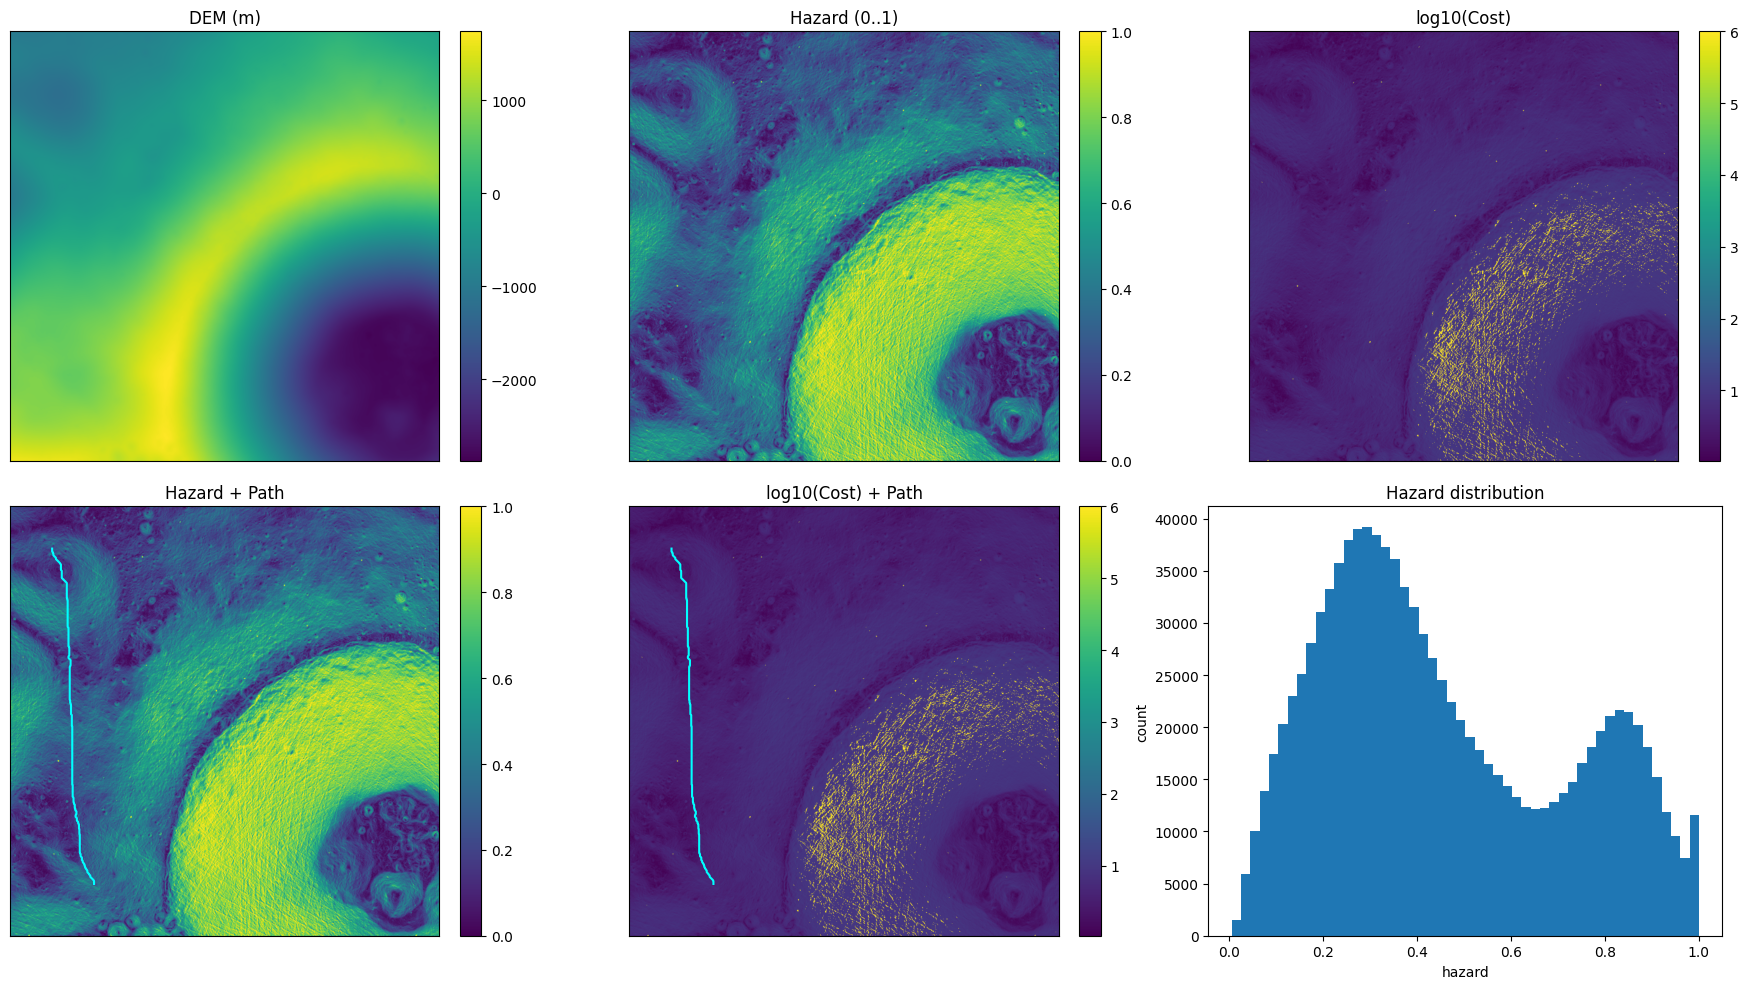

Path hazard mean: 0.22872139513492584
Path hazard max : 0.5381649732589722


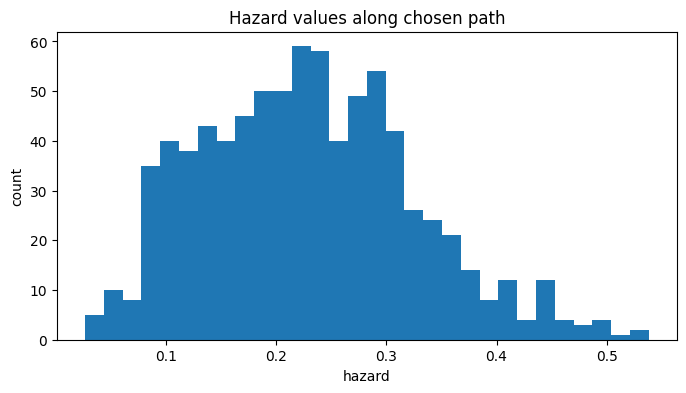

In [39]:
# References / notes:
# - Matplotlib visualisation for Endymion prototype outputs
# - Shows DEM/hazard/cost and overlays the chosen path if available

import numpy as np
import matplotlib.pyplot as plt

def plot_raster(ax, img, title, vmin=None, vmax=None):
    im = ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def overlay_path(ax, path_rc, color="cyan", lw=1.5):
    if path_rc is None or len(path_rc) == 0:
        return
    rr = path_rc[:, 0]
    cc = path_rc[:, 1]
    ax.plot(cc, rr, linewidth=lw, color=color)

# Ensure it have a path_rc variable (from    save cell)
# If not, infer from best["path_rc"].
try:
    _path_rc = path_rc
except NameError:
    if best is not None and best.get("success") and best.get("path_rc"):
        _path_rc = np.asarray(best["path_rc"], dtype=np.int32)
    else:
        _path_rc = np.zeros((0,2), dtype=np.int32)

# Basic sanity stats
print("DEM shape:", dem_m.shape, "min/max:", float(np.nanmin(dem_m)), float(np.nanmax(dem_m)))
print("Hazard shape:", hazard.shape, "min/max:", float(np.nanmin(hazard)), float(np.nanmax(hazard)))
print("Cost shape:", cost.shape, "min/max:", float(np.nanmin(cost)), float(np.nanmax(cost)))
print("Path nodes:", int(_path_rc.shape[0]))

# Make cost viewable (log compress)
cost_view = np.log10(np.clip(cost, 1.0, np.nanmax(cost)))

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_raster(axs[0,0], dem_m, "DEM (m)")
plot_raster(axs[0,1], hazard, "Hazard (0..1)", vmin=0.0, vmax=1.0)
plot_raster(axs[0,2], cost_view, "log10(Cost)")

# Hazard + path
axs[1,0].imshow(hazard, vmin=0.0, vmax=1.0)
axs[1,0].set_title("Hazard + Path")
axs[1,0].set_xticks([]); axs[1,0].set_yticks([])
overlay_path(axs[1,0], _path_rc)
plt.colorbar(axs[1,0].images[0], ax=axs[1,0], fraction=0.046, pad=0.04)

# Cost + path
axs[1,1].imshow(cost_view)
axs[1,1].set_title("log10(Cost) + Path")
axs[1,1].set_xticks([]); axs[1,1].set_yticks([])
overlay_path(axs[1,1], _path_rc)
plt.colorbar(axs[1,1].images[0], ax=axs[1,1], fraction=0.046, pad=0.04)

# Hazard distribution
hf = hazard[np.isfinite(hazard)]
axs[1,2].hist(hf, bins=50)
axs[1,2].set_title("Hazard distribution")
axs[1,2].set_xlabel("hazard"); axs[1,2].set_ylabel("count")

plt.tight_layout()
plt.show()

# Path hazard stats
if _path_rc.shape[0] > 0:
    path_h = np.array([hazard[r, c] for r, c in _path_rc], dtype=np.float32)
    print("Path hazard mean:", float(np.mean(path_h)))
    print("Path hazard max :", float(np.max(path_h)))

    plt.figure(figsize=(8,4))
    plt.hist(path_h, bins=30)
    plt.title("Hazard values along chosen path")
    plt.xlabel("hazard"); plt.ylabel("count")
    plt.show()
else:
    print("No path to analyse.")


## 11. Save navigation artefacts + evaluation
I save the run artefacts (hazard, cost, path, metadata) and compute evaluation metrics.


In [38]:
# References / origin notes:
# - Uses Endymion's Evaluator to write strict JSON metrics for the navigation run directory.
# - Saves artefacts for reproducibility (hazard/cost/path + nav_meta + metrics).

import json
from pathlib import Path
import numpy as np

# Create a run directory inside the derived output folder (same folder used for cached rasters)
run_dir = Path(out_dir) / "navigation_v1"
run_dir.mkdir(parents=True, exist_ok=True)

# Save core artefacts
np.save(run_dir / "hazard.npy", hazard_safe.astype(np.float32))
np.save(run_dir / "cost.npy", cost.astype(np.float32))
np.save(run_dir / "path_rc.npy", path_rc.astype(np.int32))

nav_meta = {
    "run_name": f"demo_{SCENARIO_NAME}",
    "tile_id": tiles[0].tile_id,
    "roi": CANONICAL_ROI,
    "nav_meta": {
        "start_rc": list(map(int, start)),
        "goal_rc": list(map(int, goal)),
        "cost_model": {
            "alpha": float(alpha),
            "hazard_block": float(hazard_block),
            "block_cost": float(block_cost),
        },
        "pathfinder": {
            "connectivity": int(CONNECTIVITY),
            "heuristic_weight": float(HEURISTIC_WEIGHT),
            "corridor_radii": list(map(int, corridor_radii)),
            "best_radius_px": best_radius_px,
        },
        "result": {
            "success": bool(best is not None and best.get("success", False)),
            "total_cost": float(best["total_cost"]) if best is not None and best.get("success", False) else None,
            "expansions": int(best["meta"].get("expansions", -1)) if best is not None else None,
        },
    },
}

(run_dir / "nav_meta.json").write_text(json.dumps(nav_meta, indent=2))

# Evaluate and save metrics.json
ev = Evaluator(run_dir=run_dir, pixel_size_m=PIXEL_SIZE_M)
metrics_path = ev.save("metrics.json")

print("Saved run artefacts to:", run_dir)
print("Saved metrics to      :", metrics_path)


Saved run artefacts to: /content/drive/MyDrive/endymion_cache/lola/derived/ldem_85s_20m/roi_7072_8096_7072_8096/navigation_v1
Saved metrics to      : /content/drive/MyDrive/endymion_cache/lola/derived/ldem_85s_20m/roi_7072_8096_7072_8096/navigation_v1/metrics.json


This code block visualizes the relationship between the corridor radius and the number of expansions, as well as the path length, from the `corridor_experiment`.

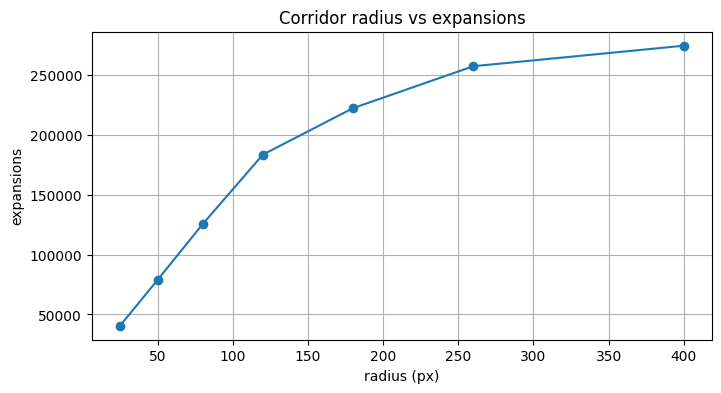

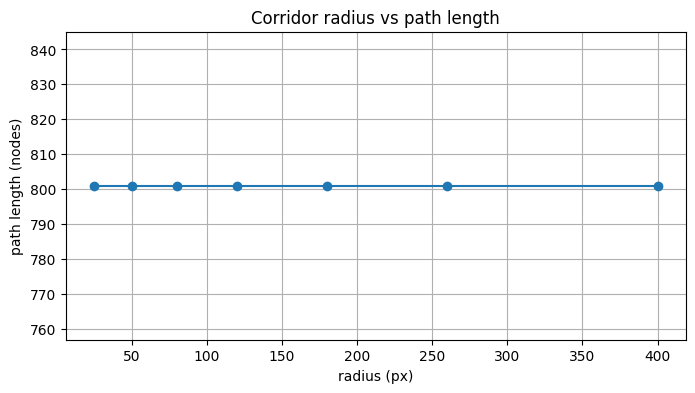

First successful radius: 25


In [40]:
import numpy as np
import matplotlib.pyplot as plt

if "corridor_experiment" in globals() and len(corridor_experiment) > 0:
    radii = np.array([r["radius_px"] for r in corridor_experiment], dtype=np.int32)
    expansions = np.array([r["expansions"] for r in corridor_experiment], dtype=np.int32)
    path_lens = np.array([r["path_len"] for r in corridor_experiment], dtype=np.int32)
    success = np.array([r["success"] for r in corridor_experiment], dtype=bool)

    plt.figure(figsize=(8,4))
    plt.plot(radii, expansions, marker="o")
    plt.title("Corridor radius vs expansions")
    plt.xlabel("radius (px)")
    plt.ylabel("expansions")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(radii, path_lens, marker="o")
    plt.title("Corridor radius vs path length")
    plt.xlabel("radius (px)")
    plt.ylabel("path length (nodes)")
    plt.grid(True)
    plt.show()

    print("First successful radius:", int(radii[success][0]) if success.any() else None)
else:
    print("corridor_experiment not found / empty.")


Lastly, an auto saved that stores the produced figures

In [41]:
from pathlib import Path

SAVE_FIGS = True

def save_figure(fig, name, out_dir):
    if not SAVE_FIGS:
        return
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    path = out_dir / f"{name}.png"
    fig.savefig(path, dpi=200, bbox_inches="tight")
    print(f"Saved figure: {path}")


In [42]:
fig = plt.gcf()
save_figure(fig, "hazard_cost_path_overview", out_dir)


Saved figure: /content/drive/MyDrive/endymion_cache/lola/derived/ldem_85s_20m/roi_7072_8096_7072_8096/hazard_cost_path_overview.png


<Figure size 640x480 with 0 Axes>

## Prototype summary
This notebook demonstrates a complete, working prototype of Endymion’s hazard-aware navigation pipeline.
It produces reproducible artefacts and evaluation outputs suitable for demonstration and benchmarking.

DEVELOP BY : Yair Cortes